In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LassoCV
import ast
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
family_to_color = {
    'IL-1': '#2D2D2A',
    'IL-10': '#4C4C47',
    'IL-17': '#686E76',
    'IL-6/IL-12': '#848FA5',
    'IL-10 (IL-20 subfamily)': '#B9BFCB',
    'Interleukin - non-classified': '#DCDFE5',
    'Interferon': '#947E91',
    'Common γ chain/IL-13/TSLP': '#C14953',
    'TNF': '#D3938C',
    'Growth factor': '#E1C3B7',
    'Other': '#E5DCC5',
    
    'Common β chain': '#B76F52',
    'Chemokine': '#D0B4BC',
    'Complement': '#7F6B39'
}

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc/data/donor_feature_importance"

In [4]:
data_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/metrics_new_donor"
df = pd.read_csv(os.path.join(data_dir, "metrics_new_donor.csv"), index_col=0)

In [5]:

with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_order.pkl", "rb") as file:
    cyto_order = pickle.load(file)

with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_to_fam.pkl", "rb") as file:
    cyto_to_family = pickle.load(file)


In [6]:
df.head()

,mean_decoded_r_sq_per_cell_type,mean_e_distance_per_cell_type,mean_mmd_per_cell_type,mean_sdiv_10_per_cell_type,mean_sdiv_100_per_cell_type,mean_deg_r_sq_per_cell_type,mean_deg_e_distance_per_cell_type,mean_deg_mmd_per_cell_type,mean_deg_sdiv_10_per_cell_type,mean_deg_sdiv_100_per_cell_type,...,e_distance_pDC,mmd_pDC,div_10_pDC,div_100_pDC,deg_decoded_r_squared_pDC,deg_e_distance_pDC,deg_mmd_pDC,deg_div_10_pDC,deg_div_100_pDC,new_run
Donor8_IL-1Ra,0.936079,18.672976,0.010558,99.468785,15.969938,0.835870,27.137565,0.039739,137.779715,22.365724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Donor12_IL-32-beta,0.880287,57.002564,0.019194,131.728360,43.893835,0.488720,78.095042,0.063817,178.566758,52.956970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Donor8_FasL,0.936261,20.548462,0.010757,101.143822,17.251914,0.816263,26.480086,0.042731,139.250231,22.540262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Donor7_OX40L,0.923112,29.121615,0.011908,104.739377,22.172538,0.763669,36.172174,0.051545,146.038442,29.380676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Donor5_BAFF,0.920968,30.491248,0.012784,105.387378,23.400425,0.689538,35.676550,0.049371,156.660900,28.123338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [7]:
def get_cytokine_importance(all_cytokines_in_train: list[str], df_d: pd.DataFrame, cytokine: str, target_variable: str = "ood_e_distance"):
    
    for d in all_cytokines_in_train:
        df_d[f"{d}_present"] = df_d.apply(lambda x: d in x["cytokine_in_train"], axis=1)

    for num_cytokines in df["num_cytokines_in_train"].unique():
        df_d[f"{num_cytokines}_present"] = df_d.apply(lambda x: x["num_cytokines_in_train"] == num_cytokines, axis=1)
    
    cols = [f"{d}_present" for d in all_cytokines_in_train] + [f"{num_cytokines}_present" for num_cytokines in df_d["num_cytokines_in_train"].unique()]
    # Prepare feature matrix and target variable
    X = df_d[cols]
    y = df_d[target_variable]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Lasso regression
    lasso = LassoCV(cv=5, random_state=0)
    lasso.fit(X_scaled, y)
    
    # Extract coefficients
    coefficients = lasso.coef_
    intercept = lasso.intercept_
    
    # Create a DataFrame with feature importance
    feature_stats = pd.DataFrame({
        'Feature': cols,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    # Add the intercept for completeness
    feature_stats.loc[len(feature_stats)] = ['Intercept', intercept]
    
    return feature_stats



In [8]:
all_cytokines_in_test = df["cytokine"].unique()

all_cytokines_in_train = list(
        set(el for i in range(len(df)) for el in ast.literal_eval(df.iloc[i]["cytokine_in_train"]))
    )

cytokine_cols = [f"{d}_present" for d in all_cytokines_in_train] + [f"{num_cytokines}_present" for num_cytokines in df["num_cytokines_in_train"].unique()]


In [9]:

train_cytos_ordered = [f"{el}_present" for el in cyto_order if el in all_cytokines_in_train]
test_cytos_ordered = [el for el in cyto_order if el in all_cytokines_in_test]
df_c = pd.DataFrame(columns=cytokine_cols)
for cytokine in all_cytokines_in_test:
    filtered_df = df[df["cytokine"]==cytokine]
    lower_bound = filtered_df["ood_e_distance"].quantile(0.0)
    upper_bound = filtered_df["ood_e_distance"].quantile(0.95)
    filtered_df = filtered_df[(filtered_df["ood_e_distance"] >= lower_bound) & (filtered_df["ood_e_distance"] <= upper_bound)]
    d = get_cytokine_importance(all_cytokines_in_train, filtered_df, cytokine).set_index("Feature")
    d.loc[f"{cytokine}_present"] = None
    df_c.loc[cytokine] = d.loc[cytokine_cols]["Coefficient"]

df_c = df_c.loc[test_cytos_ordered, train_cytos_ordered]

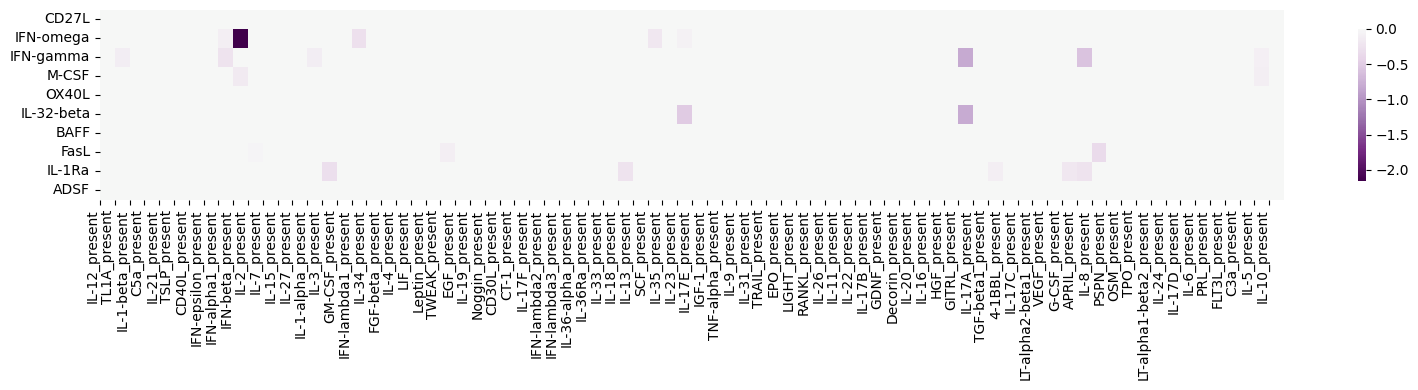

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
sns.heatmap(
    df_c,
    cmap="PRGn",            
    center=0,                  # Set 0 as the midpoint of the colormap
    linecolor='white',         # Use white borders between cells
    cbar_kws={'shrink': 0.8}   # Shrink the colorbar
)

# Ensure all x-tick labels are shown
plt.xticks(
    ticks=range(len(df_c.columns)),  # Create ticks for all columns
    labels=df_c.columns,            # Use column names as labels
    rotation=90,                    # Rotate labels for better readability
    ha='right'                      # Align labels to the right
)

# Show the plot
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")



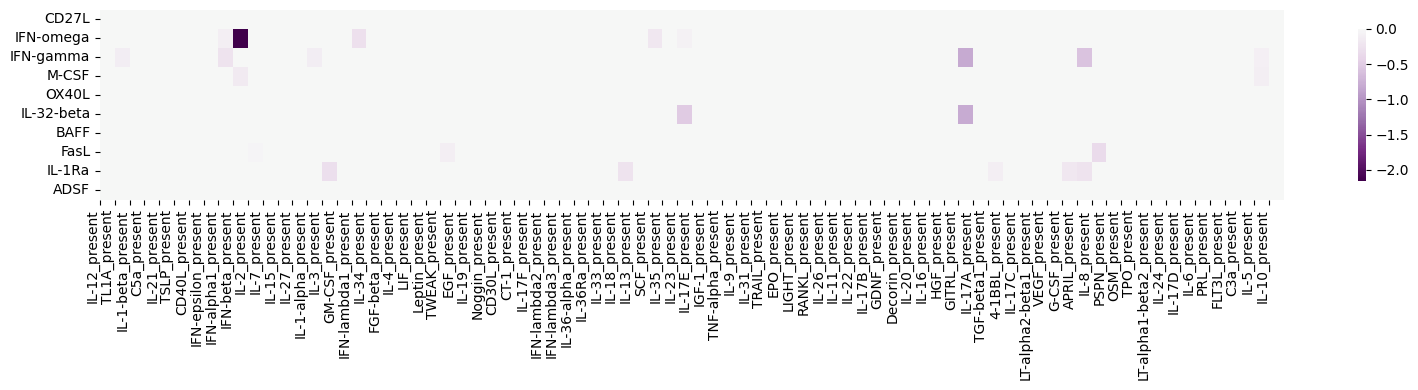

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
sns.heatmap(
    df_c,
    cmap="PRGn",            
    center=0,                  # Set 0 as the midpoint of the colormap
    linecolor='white',         # Use white borders between cells
    cbar_kws={'shrink': 0.8}   # Shrink the colorbar
)

# Ensure all x-tick labels are shown
plt.xticks(
    ticks=range(len(df_c.columns)),  # Create ticks for all columns
    labels=df_c.columns,            # Use column names as labels
    rotation=90,                    # Rotate labels for better readability
    ha='right'                      # Align labels to the right
)

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")



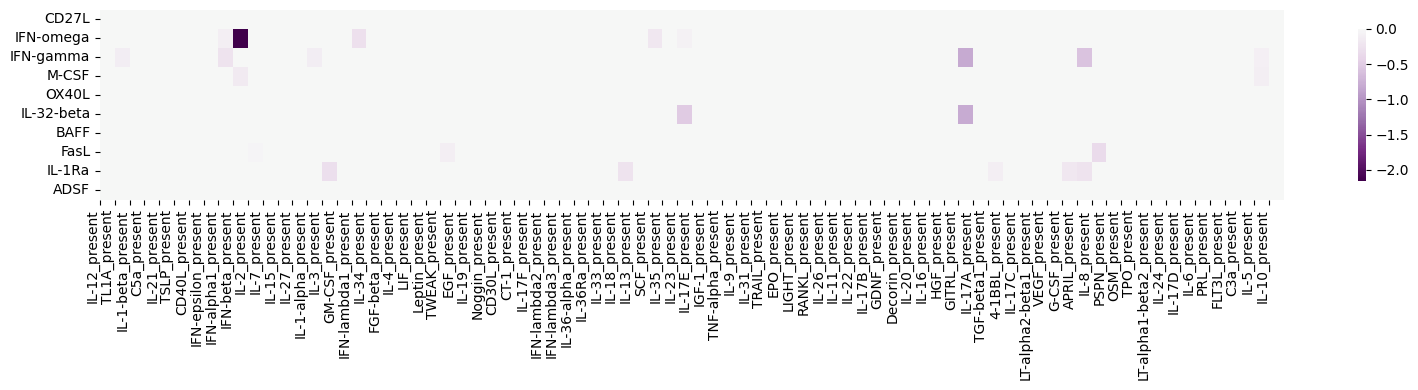

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
sns.heatmap(
    df_c,
    cmap="PRGn",            
    center=0,                  # Set 0 as the midpoint of the colormap
    linecolor='white',         # Use white borders between cells
    cbar_kws={'shrink': 0.8}   # Shrink the colorbar
)

# Ensure all x-tick labels are shown
plt.xticks(
    ticks=range(len(df_c.columns)),  # Create ticks for all columns
    labels=df_c.columns,            # Use column names as labels
    rotation=90,                    # Rotate labels for better readability
    ha='right'                      # Align labels to the right
)

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")



In [13]:
negative_entries = {
    (row_name, col_name): df_c.loc[row_name, col_name]
    for row_name in df_c.index
    for col_name in df_c.columns
    if df_c.loc[row_name, col_name] < -0.0001
}

In [14]:
data_sim_dir  = "/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/similarities"
df_sim = pd.read_csv(os.path.join(data_sim_dir, "df_cytokine_sim.csv"), index_col=0)

In [15]:
df_sim["cyto1"] = df_sim.index
df_sim = df_sim[df_sim["cyto1"].isin(all_cytokines_in_test)]
df_sim_long = pd.melt(df_sim, id_vars=["cyto1"], var_name="cyto2", value_name="similarity")
df_sim_long = df_sim_long[(df_sim_long["cyto1"]!=df_sim_long["cyto2"]) & (df_sim_long["cyto2"]!="cyto")]
df_sim_long = df_sim_long.sort_values("similarity", ascending=False)
df_sim_long["rank"] = np.arange(len(df_sim_long))

neg_entries_rank = {}
for test_cyto in all_cytokines_in_test:
    df_tmp = df_sim_long[df_sim_long["cyto1"]==test_cyto]
    df_tmp = df_tmp[df_tmp["cyto2"].isin(all_cytokines_in_train)]
    df_tmp = df_tmp.sort_values("similarity", ascending=True)
    df_tmp["rank"] = np.arange(len(df_tmp)) + 1
    neg_entries_tmp = {k:v for k,v in negative_entries.items() if test_cyto==k[0]}
    for expl_cyto in neg_entries_tmp.keys():
        neg_entries_rank[expl_cyto] = df_tmp[df_tmp["cyto2"]==expl_cyto[1].split("_")[0]]["rank"].values

neg_entries_rank = {f"{k[0]}_{k[1]}": int(v) for k,v in neg_entries_rank.items()}



neg_entries_f = {f"{k[0]}_{k[1]}": v for k,v in negative_entries.items()}
df_feature_imp = pd.DataFrame.from_dict(neg_entries_f, orient="index", columns=["feature_importance"])




sim_rank = {}
for cyto1, cyto2 in negative_entries.keys():
    sim_rank[(cyto1, cyto2)] = df_sim_long[(df_sim_long["cyto1"]==cyto1) & (df_sim_long["cyto2"]==cyto2.split("_")[0])]["rank"].values

/tmp/ipykernel_2497999/1107924202.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neg_entries_rank = {f"{k[0]}_{k[1]}": int(v) for k,v in neg_entries_rank.items()}


In [16]:
df_ranks = pd.DataFrame.from_dict(neg_entries_rank, orient="index", columns=["rank"])
df_ranks["cyto_comb"] = df_ranks.index

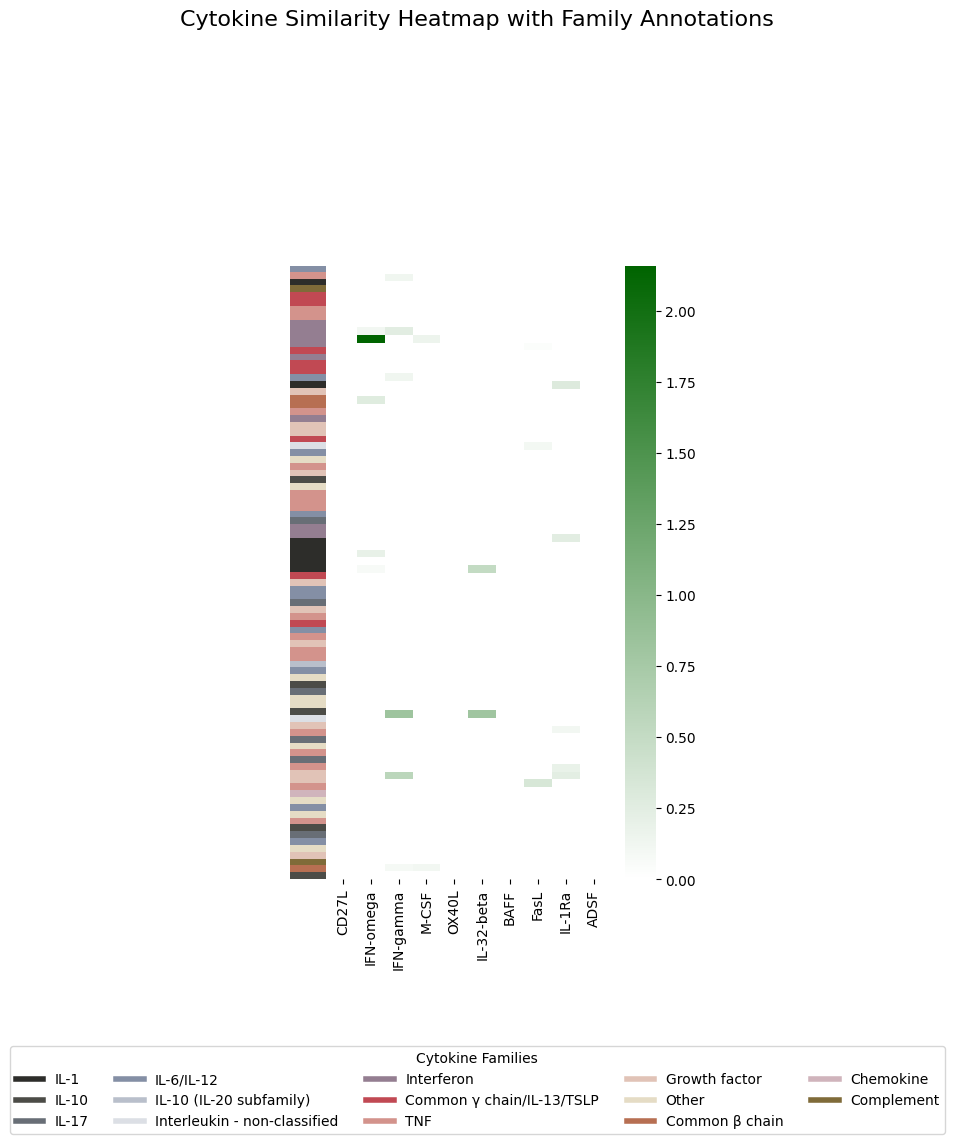

In [17]:


family_to_color = {k: mcolors.to_rgb(v) for k,v in family_to_color.items()}

# Map cytokines to colors
row_colors = [[family_to_color[cyto_to_family[cyto]]] for cyto in cyto_order]

# Set up the grid
fig = plt.figure(figsize=(5, 10))
grid = fig.add_gridspec(5, 10, wspace=0.1, hspace=0.1)

white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar

# Map the normalized colors to the data
colors = sm.to_rgba(df_ranks["rank"])



# Main heatmap
ax_main = fig.add_subplot(grid[1:, 1:])
sns.heatmap(
    -df_c.T,
    cmap=white_to_green,
    xticklabels=True,
    yticklabels=False,
    ax=ax_main,
)

# Row color bar
ax_row_colors = fig.add_subplot(grid[1:, 0])
ax_row_colors.imshow(row_colors, aspect="auto")
ax_row_colors.axis("off")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=4, label=family)
    for family, color in family_to_color.items()
]
fig.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    title="Cytokine Families",
)

# Add a title
fig.suptitle("Cytokine Similarity Heatmap with Family Annotations", fontsize=16)
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance_family_annotation.pdf"), format="pdf", bbox_inches="tight")

plt.show()

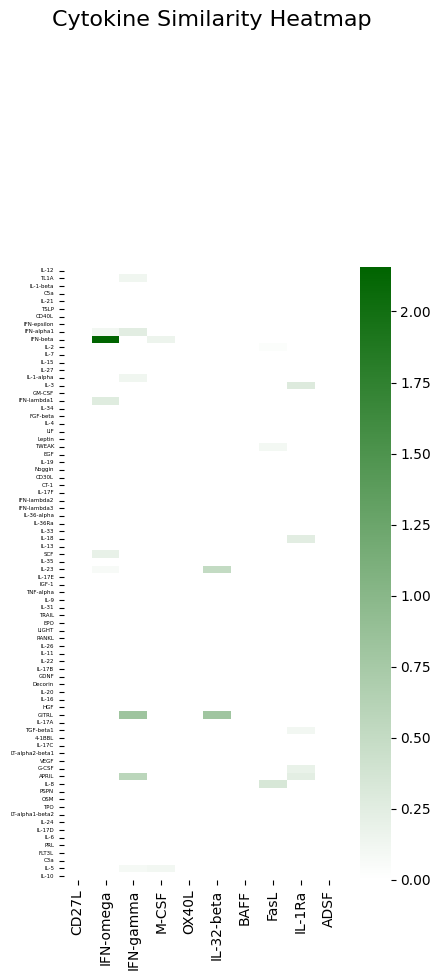

In [18]:
# Set up the grid
fig = plt.figure(figsize=(5, 10))
grid = fig.add_gridspec(5, 10, wspace=0.1, hspace=0.1)

# Custom colormap: white to dark green
white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar

# Preprocess y-axis labels to remove "_present"
yticks = [label.replace("_present", "") for label in df_c.columns]

# Main heatmap
ax_main = fig.add_subplot(grid[1:, 1:])
sns.heatmap(
    -df_c.T,
    cmap=white_to_green,
    xticklabels=True,
    yticklabels=yticks,
    ax=ax_main
)

# Reduce y-axis label size
ax_main.tick_params(axis="y", labelsize=4)

# Add a title
fig.suptitle("Cytokine Similarity Heatmap", fontsize=16)

# Save the figure
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")

plt.show()


In [19]:
negative_entries

{('IFN-omega', 'IFN-alpha1_present'): -0.11625806003458745,
 ('IFN-omega', 'IFN-beta_present'): -2.157350047667127,
 ('IFN-omega', 'IL-3_present'): -0.006825661478611387,
 ('IFN-omega', 'IFN-lambda1_present'): -0.2705155507007845,
 ('IFN-omega', 'SCF_present'): -0.19508375516256296,
 ('IFN-omega', 'IL-23_present'): -0.06803717966727846,
 ('IFN-gamma', 'TL1A_present'): -0.13275422169128753,
 ('IFN-gamma', 'IFN-alpha1_present'): -0.25274561880623786,
 ('IFN-gamma', 'IL-1-alpha_present'): -0.12990723444497718,
 ('IFN-gamma', 'GITRL_present'): -0.8231591978459825,
 ('IFN-gamma', 'APRIL_present'): -0.5757403663571514,
 ('IFN-gamma', 'IL-5_present'): -0.08519230481431816,
 ('M-CSF', 'IFN-beta_present'): -0.15495572742803668,
 ('M-CSF', 'IL-5_present'): -0.11550407597054925,
 ('IL-32-beta', 'IL-23_present'): -0.5073968254219985,
 ('IL-32-beta', 'GITRL_present'): -0.80520541750608,
 ('FasL', 'IL-2_present'): -0.042041046347822346,
 ('FasL', 'TWEAK_present'): -0.10839326787709028,
 ('FasL', 'IL

In [20]:
negative_entries

{('IFN-omega', 'IFN-alpha1_present'): -0.11625806003458745,
 ('IFN-omega', 'IFN-beta_present'): -2.157350047667127,
 ('IFN-omega', 'IL-3_present'): -0.006825661478611387,
 ('IFN-omega', 'IFN-lambda1_present'): -0.2705155507007845,
 ('IFN-omega', 'SCF_present'): -0.19508375516256296,
 ('IFN-omega', 'IL-23_present'): -0.06803717966727846,
 ('IFN-gamma', 'TL1A_present'): -0.13275422169128753,
 ('IFN-gamma', 'IFN-alpha1_present'): -0.25274561880623786,
 ('IFN-gamma', 'IL-1-alpha_present'): -0.12990723444497718,
 ('IFN-gamma', 'GITRL_present'): -0.8231591978459825,
 ('IFN-gamma', 'APRIL_present'): -0.5757403663571514,
 ('IFN-gamma', 'IL-5_present'): -0.08519230481431816,
 ('M-CSF', 'IFN-beta_present'): -0.15495572742803668,
 ('M-CSF', 'IL-5_present'): -0.11550407597054925,
 ('IL-32-beta', 'IL-23_present'): -0.5073968254219985,
 ('IL-32-beta', 'GITRL_present'): -0.80520541750608,
 ('FasL', 'IL-2_present'): -0.042041046347822346,
 ('FasL', 'TWEAK_present'): -0.10839326787709028,
 ('FasL', 'IL

In [21]:
df_sim_long["cyto_1_2"] = df_sim_long.apply(lambda x: x["cyto1"] + "_"+x["cyto2"]+"_present", axis=1)

In [22]:
df_sim_long = df_sim_long.set_index("cyto_1_2")

In [23]:
df_ranks["feature_importance"] = -df_feature_imp["feature_importance"]

In [24]:
df_ranks.head()

,rank,cyto_comb,feature_importance
IL-1Ra_IL-3_present,47,IL-1Ra_IL-3_present,0.289808
IL-1Ra_IL-18_present,80,IL-1Ra_IL-18_present,0.251156
IL-1Ra_TGF-beta1_present,17,IL-1Ra_TGF-beta1_present,0.113230
IL-1Ra_G-CSF_present,26,IL-1Ra_G-CSF_present,0.185414
IL-1Ra_APRIL_present,45,IL-1Ra_APRIL_present,0.242299


In [25]:
df_ranks = df_ranks.sort_values("rank", ascending=False)

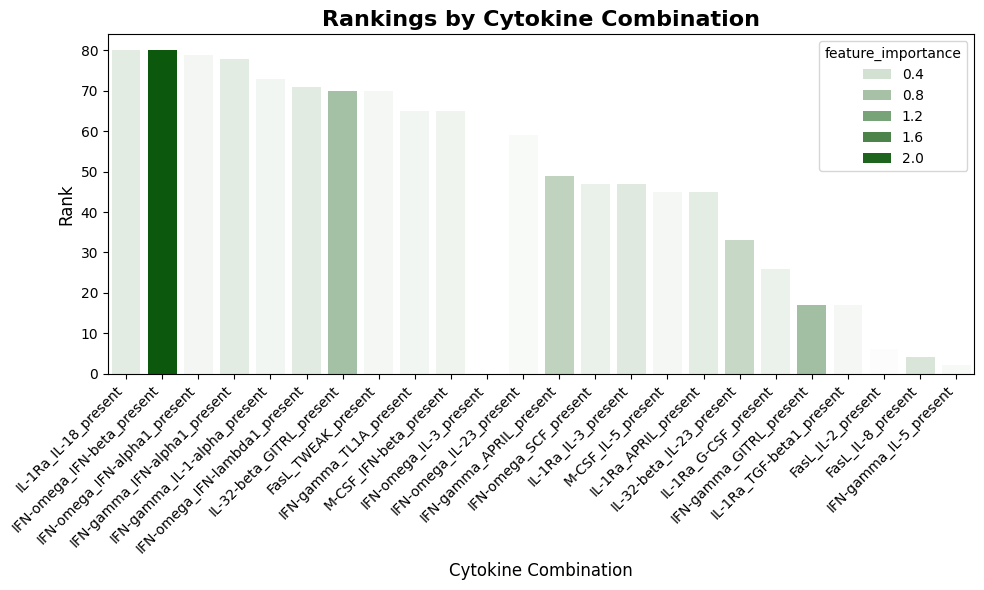

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar


# Example of an improved bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranks, x="cyto_comb", y="rank", hue="feature_importance", palette=white_to_green)

# Customizing the plot
plt.title("Rankings by Cytokine Combination", fontsize=16, weight="bold")
plt.xlabel("Cytokine Combination", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotating x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Display the plot
plt.show()


In [32]:
df_ranks.iloc[[0, 1]] = df_ranks.iloc[[1, 0]].values

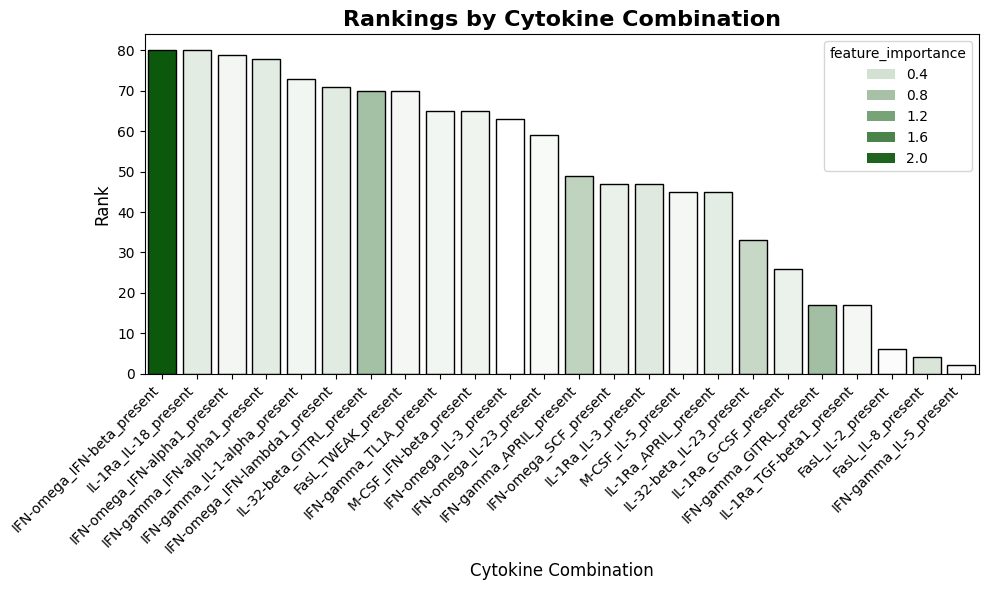

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable


white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap (ensure these values are defined appropriately)
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_ranks,
    x="cyto_comb",
    y="rank",
    hue="feature_importance",
    palette=white_to_green
)

# Add black outline around each bar
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Customizing the plot
plt.title("Rankings by Cytokine Combination", fontsize=16, weight="bold")
plt.xlabel("Cytokine Combination", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotating x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Display the plot
plt.show()


In [34]:
df_ranks.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/metrics_new_donor_analysis/df_ranks.csv")